<a href="https://colab.research.google.com/github/rafaellccouto/postech_analise_vinhos_comercio/blob/main/Analise_vinhos_comercio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analise de dados comerciais de vinhos para planos estratégicos de investimentos

###  Alguns esclarecimentos se fazem necessários, para que os usuários façam o uso correto das informações:

    Os vinhos nacionais são classificados para fins estatísticos em vinho de mesa (elaborados com uvas americanas e/ou híbridas), vinho fino de mesa (elaborados com uvas Vitis Vinifera L.) e vinho especial (corte de vinho de mesa e fino de mesa).
    Os vinhos importados, denominados de vinhos de mesa são equivalentes aos vinhos finos de mesa nacionais, pois são elaborados com uvas Vitis Vinifera L.
    Os dados constantes da base de dados ALICEweb, referentes à vinhos e espumantes são expressos em quilos, no entanto considerando que a densidade desses produtos é de aproximadamente um (1), consideramos 1 Kg = 1L.
    Os arquivos de download possuem a extensão CSV, para facilitar a importação em planilhas ou banco de dados.


In [27]:
# Análise de Dados da Cadeia Produtiva de Vinhos
# Bibliotecas básicas
import pandas as pd
import numpy as np
import os as os
from sklearn.linear_model import LinearRegression
import json

# Bibliotecas de visualização
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Configurações iniciais
pd.set_option('future.no_silent_downcasting', True)
plt.style.use('ggplot')  # Estilo mais agradável para os gráficos
sns.set_palette("husl")  # Paleta de cores harmoniosa

# Carregamento dos dados com tratamento de erros robusto
def carregar_dados(caminho):
    try:
        df = pd.read_csv(caminho, sep=';', encoding='utf-8', 
                        on_bad_lines='warn', 
                        thousands='.', 
                        decimal=',')
        print(f"Arquivo {caminho} carregado com sucesso. Shape: {df.shape}")
        return df
    except Exception as e:
        print(f"Erro ao carregar {caminho}: {str(e)}")
        return None

# Carregando todos os dataframes
dfs = {
    'comercializacao': carregar_dados('Comercializacao.csv'),
    'exportacao': carregar_dados('Exportacao.csv'),
    'importacao': carregar_dados('Importacao.csv'),
    'processamento': carregar_dados('Processamento.csv'),
    'producao': carregar_dados('Producao.csv')
}

df_comercializacao = dfs['comercializacao']
df_exportacao = dfs['exportacao']
df_importacao = dfs['importacao']
df_processamento = dfs['processamento']
df_producao = dfs['producao']

# Função para análise exploratória inicial rápida
def analise_rapida(df, nome):
    if df is not None:
        print(f"\n{'='*50}")
        print(f"Análise Exploratória: {nome}")
        print(f"{'='*50}")
        
        # Info básica
        print("\nInformações do DataFrame:")
        display(df.info())
        
        # Primeiras linhas
        print("\nPrimeiras linhas:")
        display(df.head())
        
        # Estatísticas descritivas
        print("\nEstatísticas descritivas:")
        display(df.describe(include='all'))
        
        # Valores ausentes
        print("\nValores ausentes por coluna:")
        display(df.isna().sum())

# Constantes de anos (2009-2023)
YEARS = [str(y) for y in range(2009, 2024)]
X_YEARS = np.array(range(2009, 2024))

# Função utilitária: converte valores variados para float de forma segura
def to_float_safe(v):
    """Converte diferentes formatos de número para float, tratando nulos e formatos locais.
    Retorna np.nan em caso de falha."""
    if pd.isna(v):
        return np.nan
    if isinstance(v, (int, float, np.floating, np.integer)):
        return float(v)
    s = str(v).strip()
    if s == '':
        return np.nan
    # remover espaços e separadores de milhares não quebra
    s = s.replace('\xa0', '').replace(' ', '')
    # trocar vírgula decimal por ponto quando for necessário
    if s.count(',') > 0 and s.count('.') == 0:
        s = s.replace(',', '.')
    # Se houver pontos e vírgulas, supõe-se formato 1.234.567,89 -> remover pontos e trocar vírgula
    if '.' in s and ',' in s:
        s = s.replace('.', '')
        s = s.replace(',', '.')
    # remover símbolos monetários
    s = s.replace('R$', '').replace('$', '')
    try:
        return float(s)
    except Exception:
        return np.nan

# Função compartilhada para plotar os top 5 coeficientes positivos
def plot_top5_time_series(df_reg, df_ts, titulo, ylabel, nome_arquivo):
    """Plota as séries temporais (2009-2023) e as retas de regressão para os 5 maiores
    coeficientes angulares positivos.

    Parâmetros:
    - df_reg: DataFrame com colunas 'País', 'Coeficiente_Angular', 'Equacao_Linear'
    - df_ts: DataFrame com séries anuais colunas '2009'..'2023' e coluna 'País'
    - titulo: título do gráfico
    - ylabel: rótulo do eixo y
    - nome_arquivo: caminho para salvar o PNG (opcional)
    """
    # Selecionar apenas coeficientes positivos e pegar os 5 maiores
    df_pos = df_reg[df_reg['Coeficiente_Angular'] > 0].copy()
    if df_pos.empty:
        print(f"Nenhum coeficiente angular positivo encontrado para {titulo}")
        return
    df_top5 = df_pos.nlargest(5, 'Coeficiente_Angular')
    paises = df_top5['País'].tolist()

    cores = plt.cm.tab10(np.linspace(0, 1, max(5, len(paises))))

    plt.figure(figsize=(12, 8))

    for i, pais in enumerate(paises):
        row = df_ts[df_ts['País'] == pais]
        if row.empty:
            print(f"Aviso: país '{pais}' não encontrado nas séries temporais")
            continue

        # Extrair série 2009-2023
        y_vals = []
        for ano in YEARS:
            if ano in row.columns:
                raw = row.iloc[0][ano]
                y_vals.append(to_float_safe(raw))
            else:
                y_vals.append(np.nan)

        y = np.array(y_vals, dtype=float)
        mask = ~np.isnan(y)
        if mask.sum() < 2:
            print(f"Dados insuficientes para regressão de '{pais}'")
            continue

        # Ajustar regressão nos anos disponíveis
        X = X_YEARS[mask].reshape(-1, 1)
        y_fit = y[mask]
        model = LinearRegression()
        model.fit(X, y_fit)
        # Prever ao longo de toda a linha do tempo para desenhar a reta
        y_line = model.predict(X_YEARS.reshape(-1, 1))

        # Plotar série e reta
        plt.plot(X_YEARS, y_line, color=cores[i], linestyle='-', linewidth=2,
                 label=f"{pais} (inclinação={model.coef_[0]:.2f})")
        plt.scatter(X_YEARS[mask], y[mask], color=cores[i], s=40)

        # Anotar o país no final da reta
        try:
            ultimo = float(y_line[-1])
            plt.text(2023 + 0.12, ultimo, pais, color=cores[i], va='center')
        except Exception:
            pass

    plt.title(titulo, fontsize=14, fontweight='bold')
    plt.xlabel('Ano', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xlim(2008.8, 2024.5)
    plt.grid(alpha=0.3)
    plt.legend(loc='upper left', fontsize=9)
    plt.tight_layout()
    if nome_arquivo:
        # salvar somente se o arquivo ainda não existir (sem sobrescrever)
        try:
            if not os.path.exists(nome_arquivo):
                plt.savefig(nome_arquivo, dpi=300, bbox_inches='tight')
                print(f"Gráfico salvo como '{nome_arquivo}'")
            else:
                print(f"Arquivo '{nome_arquivo}' já existe.")
        except Exception as e:
            print(f"Aviso ao verificar/salvar arquivo '{nome_arquivo}': {e}")
    plt.show()

    # Mostrar tabela resumida dos top 5
    display(df_top5[['País', 'Coeficiente_Angular', 'Equacao_Linear']].reset_index(drop=True))

# Executar análise rápida inicial para todos os dataframes carregados
for nome, df in dfs.items():
    analise_rapida(df, nome)


Arquivo Comercializacao.csv carregado com sucesso. Shape: (62, 57)
Arquivo Exportacao.csv carregado com sucesso. Shape: (137, 110)
Arquivo Importacao.csv carregado com sucesso. Shape: (68, 110)
Arquivo Processamento.csv carregado com sucesso. Shape: (139, 57)
Arquivo Producao.csv carregado com sucesso. Shape: (51, 57)

Análise Exploratória: comercializacao

Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 57 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       62 non-null     int64 
 1   control  61 non-null     object
 2   Produto  62 non-null     object
 3   1970     62 non-null     int64 
 4   1971     62 non-null     int64 
 5   1972     62 non-null     int64 
 6   1973     62 non-null     int64 
 7   1974     62 non-null     int64 
 8   1975     62 non-null     int64 
 9   1976     62 non-null     int64 
 10  1977     62 non-null     int64 
 11  1978     62 non-null     

None


Primeiras linhas:


,id,control,Produto,1970,1971,1972,1973,1974,1975,1976,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,1,VINHO DE MESA,VINHO DE MESA,98327606,114399031,118377367,116617910,94173324,108031792,139238614,...,206404427,209198468,166769622,176059959,177186273,180446489,215557931,210012238,187939996,187016848
1,2,vm_Tinto,Tinto,83300735,98522869,101167932,98196747,77167303,91528090,116407222,...,178250072,182028785,146646365,154309442,155115499,158519218,189573423,185653678,165067340,165097539
2,3,vm_Rosado,Rosado,107681,542274,7770851,8425617,8891367,7261777,11748047,...,1419855,1409002,1391942,1097426,1972944,1265435,1394901,1931606,2213723,2520748
3,4,vm_Branco,Branco,14919190,15333888,9438584,9995546,8114654,9241925,11083345,...,26734500,25760681,18731315,20653091,20097830,20661836,24589607,22426954,20658933,19398561
4,5,VINHO FINO DE MESA,VINHO FINO DE MESA,4430629,4840369,5602091,7202830,7571802,8848303,14095648,...,20424983,20141631,19630158,15874354,14826143,15684588,24310834,27080445,21533487,18589310



Estatísticas descritivas:


,id,control,Produto,1970,1971,1972,1973,1974,1975,1976,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
count,62.000000,61,62,6.200000e+01,6.200000e+01,6.200000e+01,6.200000e+01,6.200000e+01,6.200000e+01,6.200000e+01,...,6.200000e+01,6.200000e+01,6.200000e+01,6.200000e+01,6.200000e+01,6.200000e+01,6.200000e+01,6.200000e+01,6.200000e+01,6.200000e+01
unique,NaN,58,56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,vm_Tinto,Tinto,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,31.500000,NaN,NaN,4.285390e+06,4.852292e+06,5.172139e+06,5.313006e+06,4.481220e+06,5.016926e+06,6.458909e+06,...,1.108466e+07,1.148983e+07,9.416295e+06,9.850569e+06,1.046188e+07,1.344737e+07,1.440038e+07,1.477322e+07,1.439002e+07,1.457866e+07
std,18.041619,NaN,NaN,1.635975e+07,1.909915e+07,1.969129e+07,1.931093e+07,1.553042e+07,1.793219e+07,2.298172e+07,...,3.605890e+07,3.761433e+07,3.015712e+07,3.219878e+07,3.419452e+07,3.832344e+07,4.204562e+07,4.159378e+07,3.920502e+07,4.038657e+07
min,1.000000,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,16.250000,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.050000e+01,2.856750e+03,1.953250e+03,2.379750e+03,4.161750e+03,2.377500e+03
50%,31.500000,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,8.067300e+04,1.190405e+05,6.604850e+04,5.596700e+04,1.214570e+05,3.387175e+05,1.988605e+05,3.282575e+05,2.945420e+05,3.783910e+05
75%,46.750000,NaN,NaN,1.220420e+06,1.219804e+06,1.819606e+06,2.034500e+06,1.845616e+06,2.186432e+06,3.285852e+06,...,3.906140e+06,3.343750e+06,2.935858e+06,2.694804e+06,3.332818e+06,5.321690e+06,5.815971e+06,5.620650e+06,5.221489e+06,4.773561e+06



Valores ausentes por coluna:


id         0
control    1
Produto    0
1970       0
1971       0
1972       0
1973       0
1974       0
1975       0
1976       0
1977       0
1978       0
1979       0
1980       0
1981       0
1982       0
1983       0
1984       0
1985       0
1986       0
1987       0
1988       0
1989       0
1990       0
1991       0
1992       0
1993       0
1994       0
1995       0
1996       0
1997       0
1998       0
1999       0
2000       0
2001       0
2002       0
2003       0
2004       0
2005       0
2006       0
2007       0
2008       0
2009       0
2010       0
2011       0
2012       0
2013       0
2014       0
2015       0
2016       0
2017       0
2018       0
2019       0
2020       0
2021       0
2022       0
2023       0
dtype: int64


Análise Exploratória: exportacao

Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Columns: 110 entries, Id to 2023.1
dtypes: int64(109), object(1)
memory usage: 117.9+ KB


None


Primeiras linhas:


,Id,País,1970,1970.1,1971,1971.1,1972,1972.1,1973,1973.1,...,2019,2019.1,2020,2020.1,2021,2021.1,2022,2022.1,2023,2023.1
0,1,Afeganistão,0,0,0,0,0,0,0,0,...,0,0,0,0,11,46,0,0,0,0
1,2,África do Sul,0,0,0,0,0,0,0,0,...,26,95,4,21,0,0,0,0,117,698
2,3,"Alemanha, República Democrática",0,0,0,0,4168,2630,12000,8250,...,3660,25467,6261,32605,2698,6741,7630,45367,4806,31853
3,4,Angola,0,0,0,0,0,0,0,0,...,345,1065,0,0,0,0,4068,4761,0,0
4,5,Anguilla,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



Estatísticas descritivas:


,Id,País,1970,1970.1,1971,1971.1,1972,1972.1,1973,1973.1,...,2019,2019.1,2020,2020.1,2021,2021.1,2022,2022.1,2023,2023.1
count,137.000000,137,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,...,1.370000e+02,1.370000e+02,1.370000e+02,1.370000e+02,1.370000e+02,1.370000e+02,1.370000e+02,1.370000e+02,1.370000e+02,1.370000e+02
unique,NaN,137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Afeganistão,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,69.000000,NaN,992.766423,295.620438,2053.321168,609.233577,2781.167883,883.919708,3439.927007,1275.854015,...,2.301367e+04,4.331990e+04,3.218772e+04,4.436707e+04,5.882266e+04,7.191199e+04,5.128455e+04,7.989257e+04,4.042984e+04,6.513194e+04
std,39.692569,NaN,7894.375593,2168.514649,20401.448066,5528.316608,25270.627095,7386.674399,29007.997816,10052.798972,...,2.075268e+05,3.321611e+05,2.845511e+05,3.371742e+05,5.596577e+05,6.183216e+05,4.388905e+05,6.202506e+05,3.273649e+05,4.786300e+05
min,1.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,35.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,69.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,4.000000e+00,1.300000e+01,9.000000e+00,2.000000e+01,2.000000e+01,6.000000e+01,1.100000e+01,3.100000e+01
75%,103.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.280000e+02,2.144000e+03,1.013000e+03,3.824000e+03,1.313000e+03,6.525000e+03,1.521000e+03,6.145000e+03,2.485000e+03,7.402000e+03



Valores ausentes por coluna:


Id        0
País      0
1970      0
1970.1    0
1971      0
         ..
2021.1    0
2022      0
2022.1    0
2023      0
2023.1    0
Length: 110, dtype: int64


Análise Exploratória: importacao

Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Columns: 110 entries, Id to 2023.1
dtypes: float64(1), int64(108), object(1)
memory usage: 58.6+ KB


None


Primeiras linhas:


,Id,País,1970,1970.1,1971,1971.1,1972,1972.1,1973,1973.1,...,2019,2019.1,2020,2020.1,2021,2021.1,2022,2022.1,2023,2023.1
0,1,Africa do Sul,0,0.0,0,0,0,0,0,0,...,1092042,3604038,627150,1701072,859169,2508140,738116,2266827,522733,1732850
1,2,Alemanha,52297,30498.0,34606,26027,134438,92103,111523,98638,...,101055,412794,136992,504168,106541,546967,92600,438595,102456,557947
2,3,Argélia,0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Arábia Saudita,0,0.0,0,0,0,0,0,0,...,0,0,0,0,2510,8761,0,0,8,161
4,5,Argentina,19525,12260.0,24942,15022,104906,58137,116887,76121,...,16548931,54527380,22610267,66322932,26869241,79527959,27980574,87519642,25276991,83918138



Estatísticas descritivas:


,Id,País,1970,1970.1,1971,1971.1,1972,1972.1,1973,1973.1,...,2019,2019.1,2020,2020.1,2021,2021.1,2022,2022.1,2023,2023.1
count,68.00000,68,68.000000,67.000000,68.000000,68.000000,6.800000e+01,6.800000e+01,6.800000e+01,6.800000e+01,...,6.800000e+01,6.800000e+01,6.800000e+01,6.800000e+01,6.800000e+01,6.800000e+01,6.800000e+01,6.800000e+01,6.800000e+01,6.800000e+01
unique,NaN,68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Africa do Sul,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,34.50000,NaN,21243.794118,13192.328358,21325.808824,13777.264706,4.061841e+04,2.778746e+04,6.030551e+04,4.960757e+04,...,1.679050e+06,5.056134e+06,2.163752e+06,5.921959e+06,2.274861e+06,6.643104e+06,2.170598e+06,6.352634e+06,2.025189e+06,6.298421e+06
std,19.77372,NaN,101926.518875,67145.495697,111101.432182,76186.656730,2.050135e+05,1.509046e+05,3.455084e+05,2.770566e+05,...,7.091429e+06,2.012029e+07,9.646107e+06,2.436089e+07,9.578220e+06,2.609990e+07,9.431418e+06,2.599889e+07,8.667761e+06,2.476976e+07
min,1.00000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,17.75000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,34.50000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.875000e+02,1.446500e+03,0.000000e+00,0.000000e+00,8.500000e+00,1.490000e+02,5.000000e-01,2.000000e+00,5.000000e+01,1.705500e+03
75%,51.25000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.177000e+04,1.079872e+05,1.591975e+04,5.302075e+04,2.464500e+04,1.010772e+05,2.998400e+04,8.796700e+04,3.079825e+04,1.278975e+05



Valores ausentes por coluna:


Id        0
País      0
1970      0
1970.1    1
1971      0
         ..
2021.1    0
2022      0
2022.1    0
2023      0
2023.1    0
Length: 110, dtype: int64


Análise Exploratória: processamento

Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 57 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        139 non-null    int64  
 1   control   139 non-null    object 
 2   cultivar  139 non-null    object 
 3   1970      139 non-null    int64  
 4   1971      139 non-null    int64  
 5   1972      139 non-null    int64  
 6   1973      139 non-null    int64  
 7   1974      139 non-null    int64  
 8   1975      139 non-null    int64  
 9   1976      139 non-null    int64  
 10  1977      139 non-null    int64  
 11  1978      139 non-null    int64  
 12  1979      139 non-null    int64  
 13  1980      139 non-null    int64  
 14  1981      139 non-null    int64  
 15  1982      139 non-null    int64  
 16  1983      139 non-null    int64  
 17  1984      139 non-null    int64  
 18  1985      139 non-null    int64  
 19  1986   

None


Primeiras linhas:


,id,control,cultivar,1970,1971,1972,1973,1974,1975,1976,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,1,TINTAS,TINTAS,10448228,11012833,10798824,8213674,17457849,22593885,20265190,...,29810706,29935627,13370866,32850915,26868514,nd,28003505,93296587,*,35881118.23
1,2,ti_Alicante Bouschet,Alicante Bouschet,0,0,0,0,0,0,0,...,1456305,1519576,908841,2040198,2103844,nd,2272985,811140,*,4108858.21
2,3,ti_Ancelota,Ancelota,0,0,0,0,0,0,0,...,937844,773526,179028,733907,492106,nd,481402,6513974,*,783688.39
3,4,ti_Aramon,Aramon,0,0,0,0,0,0,0,...,0,0,0,0,0,nd,0,0,*,0.00
4,5,ti_Alfrocheiro,Alfrocheiro,0,0,0,0,0,0,0,...,0,0,0,0,0,nd,0,0,*,0.00



Estatísticas descritivas:


,id,control,cultivar,1970,1971,1972,1973,1974,1975,1976,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
count,139.000000,139,139,1.390000e+02,1.390000e+02,1.390000e+02,1.390000e+02,1.390000e+02,1.390000e+02,1.390000e+02,...,1.390000e+02,1.390000e+02,1.390000e+02,1.390000e+02,1.390000e+02,139,1.390000e+02,1.390000e+02,139,1.370000e+02
unique,NaN,138,139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,1,NaN
top,NaN,br_Mistura de uvas viníferas,TINTAS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,nd,NaN,NaN,*,NaN
freq,NaN,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,139,NaN,NaN,139,NaN
mean,70.000000,NaN,NaN,4.216801e+05,4.774255e+05,4.154287e+05,2.939219e+05,6.199097e+05,7.475624e+05,7.204421e+05,...,9.435951e+05,1.008147e+06,4.624494e+05,1.106606e+06,9.437506e+05,NaN,9.929168e+05,2.367810e+06,NaN,1.453393e+06
std,40.269923,NaN,NaN,2.032006e+06,2.408042e+06,2.038885e+06,1.398093e+06,2.983121e+06,3.525315e+06,3.427802e+06,...,4.198300e+06,4.486448e+06,2.070321e+06,4.921597e+06,4.192152e+06,NaN,4.411265e+06,1.030022e+07,NaN,6.581549e+06
min,1.000000,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00
25%,35.500000,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00
50%,70.000000,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.890000e+03,1.110000e+03,0.000000e+00,1.340000e+03,2.060000e+03,NaN,1.540000e+03,3.110000e+03,NaN,4.510000e+03
75%,104.500000,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.155805e+05,1.358660e+05,5.355100e+04,1.120775e+05,1.215175e+05,NaN,1.804950e+05,4.667580e+05,NaN,1.718660e+05



Valores ausentes por coluna:


id          0
control     0
cultivar    0
1970        0
1971        0
1972        0
1973        0
1974        0
1975        0
1976        0
1977        0
1978        0
1979        0
1980        0
1981        0
1982        0
1983        0
1984        0
1985        0
1986        0
1987        0
1988        0
1989        0
1990        0
1991        0
1992        0
1993        0
1994        0
1995        0
1996        0
1997        0
1998        0
1999        0
2000        0
2001        0
2002        0
2003        0
2004        0
2005        0
2006        0
2007        0
2008        0
2009        0
2010        0
2011        0
2012        0
2013        0
2014        0
2015        0
2016        0
2017        0
2018        0
2019        0
2020        0
2021        0
2022        0
2023        2
dtype: int64


Análise Exploratória: producao

Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 57 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       51 non-null     int64 
 1   control  51 non-null     object
 2   produto  51 non-null     object
 3   1970     51 non-null     int64 
 4   1971     51 non-null     int64 
 5   1972     51 non-null     int64 
 6   1973     51 non-null     int64 
 7   1974     51 non-null     int64 
 8   1975     51 non-null     int64 
 9   1976     51 non-null     int64 
 10  1977     51 non-null     int64 
 11  1978     51 non-null     int64 
 12  1979     51 non-null     int64 
 13  1980     51 non-null     int64 
 14  1981     51 non-null     int64 
 15  1982     51 non-null     int64 
 16  1983     51 non-null     int64 
 17  1984     51 non-null     int64 
 18  1985     51 non-null     int64 
 19  1986     51 non-null     int64 
 20  1987     51 non-nul

None


Primeiras linhas:


,id,control,produto,1970,1971,1972,1973,1974,1975,1976,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,1,VINHO DE MESA,VINHO DE MESA,217208604,154264651,146953297,116710345,193875345,177401209,144565438,...,196173123,210308560,86319015,255015187,218375636,144629737,124200414,173899995,195031611,169762429
1,2,vm_Tinto,Tinto,174224052,121133369,118180926,88589019,146544484,144274134,118360170,...,157776363,169811472,75279191,1365957,188270142,121045115,103916391,146075996,162844214,139320884
2,3,vm_Branco,Branco,748400,1160500,1812367,243900,4138768,1441507,1871473,...,37438069,39557250,10727099,217527985,29229970,22032828,19568734,26432799,30198430,27910299
3,4,vm_Rosado,Rosado,42236152,31970782,26960004,27877426,43192093,31685568,24333795,...,958691,939838,312725,36121245,875524,1551794,715289,1391200,1988968,2531246
4,5,VINHO FINO DE MESA (VINIFERA),VINHO FINO DE MESA (VINIFERA),23899346,23586062,21078771,12368410,31644124,39424590,34500590,...,38464314,37148982,18070626,44537870,38707220,37615422,32516686,43474998,47511796,46268556



Estatísticas descritivas:


,id,control,produto,1970,1971,1972,1973,1974,1975,1976,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
count,51.000000,51,51,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,...,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01
unique,NaN,51,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,VINHO DE MESA,Tinto,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,26.000000,NaN,NaN,1.005373e+07,7.585407e+06,7.210040e+06,6.172419e+06,1.072253e+07,1.060623e+07,7.921217e+06,...,1.467719e+07,1.736085e+07,7.864719e+06,1.905223e+07,1.638247e+07,1.580154e+07,1.249067e+07,1.911132e+07,1.752368e+07,1.795266e+07
std,14.866069,NaN,NaN,3.880896e+07,2.744967e+07,2.628082e+07,2.089229e+07,3.480845e+07,3.317688e+07,2.642639e+07,...,3.798277e+07,4.353093e+07,1.940315e+07,5.084260e+07,4.379813e+07,3.833873e+07,2.914619e+07,4.571075e+07,4.352044e+07,4.426636e+07
min,1.000000,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,13.500000,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.210000e+02,0.000000e+00,0.000000e+00
50%,26.000000,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.700000e+03,9.220000e+02,0.000000e+00,3.000000e+03,2.000000e+03,3.251900e+04,4.600000e+04,3.000000e+04,5.000000e+03,1.720000e+04
75%,38.500000,NaN,NaN,8.956600e+05,8.658000e+05,1.182465e+06,3.784000e+05,2.798100e+05,1.235000e+05,2.467500e+05,...,1.504279e+06,1.536993e+06,1.033048e+06,1.759016e+06,1.533595e+06,1.757118e+06,2.747322e+06,3.824400e+06,3.138016e+06,3.974682e+06



Valores ausentes por coluna:


id         0
control    0
produto    0
1970       0
1971       0
1972       0
1973       0
1974       0
1975       0
1976       0
1977       0
1978       0
1979       0
1980       0
1981       0
1982       0
1983       0
1984       0
1985       0
1986       0
1987       0
1988       0
1989       0
1990       0
1991       0
1992       0
1993       0
1994       0
1995       0
1996       0
1997       0
1998       0
1999       0
2000       0
2001       0
2002       0
2003       0
2004       0
2005       0
2006       0
2007       0
2008       0
2009       0
2010       0
2011       0
2012       0
2013       0
2014       0
2015       0
2016       0
2017       0
2018       0
2019       0
2020       0
2021       0
2022       0
2023       0
dtype: int64

In [28]:
# Garantir dataframes auxiliares necessários
def criar_exportacao_e_importacao_auxiliares():
    global exportacao_qtd, exportacao_valor, importacao_qtd, importacao_valor
    try:
        if 'exportacao_qtd' not in globals() or exportacao_qtd is None:
            exportacao_qtd = df_exportacao.copy() if df_exportacao is not None else None
        if 'exportacao_valor' not in globals() or exportacao_valor is None:
            exportacao_valor = df_exportacao.copy() if df_exportacao is not None else None
        if 'importacao_qtd' not in globals() or importacao_qtd is None:
            importacao_qtd = df_importacao.copy() if df_importacao is not None else None
        if 'importacao_valor' not in globals() or importacao_valor is None:
            importacao_valor = df_importacao.copy() if df_importacao is not None else None
        print("DataFrames auxiliares criados/confirmados (exportacao_qtd/valor, importacao_qtd/valor).")
    except Exception as e:
        print("Não foi possível criar dataframes auxiliares:", e)

# Executar a criação
criar_exportacao_e_importacao_auxiliares()


DataFrames auxiliares criados/confirmados (exportacao_qtd/valor, importacao_qtd/valor).


## Filtragem básica de dados: Últimos 15 anos (2009 - 2023), zerar dados nulos e consolidar dados semestrais em um ano só.

### Os valores nulos podem ser 0 pois representa a sua insignificância por não ter registro da EMBRAPA e não é possível valores menores que 0 para as grandezas analisadas

### Comercialização

In [29]:
comercializacaofiltrada = df_comercializacao.copy()

# Identificar colunas de ano a serem removidas (1970 a 2008)
anos_para_remover = [str(ano) for ano in range(1970, 2009)]

# Filtrar apenas as colunas de ano que existem no DataFrame
colunas_para_remover = [coluna for coluna in anos_para_remover if coluna in comercializacaofiltrada.columns]

# Remover as colunas
comercializacaofiltrada = comercializacaofiltrada.drop(columns=colunas_para_remover, errors='ignore')

# Substituir valores nulos e NaN por 0
comercializacaofiltrada = comercializacaofiltrada.fillna(0)

print("Primeiras linhas do DataFrame após remoção dos anos anteriores a 2009 e substituição de nulos/NaN por 0:")
print(comercializacaofiltrada.head())


Primeiras linhas do DataFrame após remoção dos anos anteriores a 2009 e substituição de nulos/NaN por 0:
   id              control              Produto       2009       2010  \
0   1        VINHO DE MESA        VINHO DE MESA  234525979  221242945   
1   2             vm_Tinto                Tinto  193004182  188649074   
2   3            vm_Rosado               Rosado    2307580    2036928   
3   4            vm_Branco               Branco   39214217   30556943   
4   5  VINHO  FINO DE MESA  VINHO  FINO DE MESA   33080270   21390159   

        2011       2012       2013       2014       2015       2016  \
0  230310468  206969571  221590810  206404427  209198468  166769622   
1  196562722  173964776  188033494  178250072  182028785  146646365   
2    1668823    1738134    1777648    1419855    1409002    1391942   
3   32078923   31266661   31779668   26734500   25760681   18731315   
4   19967310   22469950   27912934   20424983   20141631   19630158   

        2017       2018      

In [30]:
comercializacaofiltrada.head()

,id,control,Produto,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,1,VINHO DE MESA,VINHO DE MESA,234525979,221242945,230310468,206969571,221590810,206404427,209198468,166769622,176059959,177186273,180446489,215557931,210012238,187939996,187016848
1,2,vm_Tinto,Tinto,193004182,188649074,196562722,173964776,188033494,178250072,182028785,146646365,154309442,155115499,158519218,189573423,185653678,165067340,165097539
2,3,vm_Rosado,Rosado,2307580,2036928,1668823,1738134,1777648,1419855,1409002,1391942,1097426,1972944,1265435,1394901,1931606,2213723,2520748
3,4,vm_Branco,Branco,39214217,30556943,32078923,31266661,31779668,26734500,25760681,18731315,20653091,20097830,20661836,24589607,22426954,20658933,19398561
4,5,VINHO FINO DE MESA,VINHO FINO DE MESA,33080270,21390159,19967310,22469950,27912934,20424983,20141631,19630158,15874354,14826143,15684588,24310834,27080445,21533487,18589310


In [31]:
arquivo = 'comercializacao_filtrada.csv'
if not os.path.exists(arquivo):
    comercializacaofiltrada.to_csv(arquivo, index=False)
    print(f"DataFrame exportado para '{arquivo}'.")
else:
    print(f"Arquivo '{arquivo}' já está gerado.")


Arquivo 'comercializacao_filtrada.csv' já está gerado.


### Exportação

In [32]:
def split_dataframe(df):
    """
    Separa o DataFrame original em dois:
    1. exportacao_qtd: contém apenas os anos de 2009-2023 (sem sufixo .1)
    2. exportacao_valor: contém os anos de 2009-2023 com sufixo .1 (removendo o '.1' dos nomes)
    
    Parâmetros:
    df -- DataFrame original
    
    Retorna:
    Tupla com (exportacao_qtd, exportacao_valor)
    """
    # Criar listas de colunas para cada DataFrame
    cols_qtd = [col for col in df.columns if not col.endswith('.1') and col.isdigit()]
    cols_valor = [col for col in df.columns if col.endswith('.1')]
    
    # Filtrar apenas colunas de 2009-2023
    years_range = set(str(year) for year in range(2009, 2024))
    
    cols_qtd = [col for col in cols_qtd if col in years_range]
    cols_valor = [col for col in cols_valor if col[:-2] in years_range]
    
    # Criar DataFrames separados mantendo todas as outras colunas não-numéricas
    other_cols = [col for col in df.columns if not (col.isdigit() or col.endswith('.1'))]
    
    exportacao_qtd = df[other_cols + cols_qtd].copy()
    
    # Para exportacao_valor, remover o '.1' dos nomes das colunas
    exportacao_valor = df[other_cols + cols_valor].copy()
    exportacao_valor.columns = other_cols + [col[:-2] for col in cols_valor]
    
    return exportacao_qtd, exportacao_valor

In [33]:
# Verifica e exporta o DataFrame de quantidades
arquivo_qtd = 'exportacao_qtd.csv'
if not os.path.exists(arquivo_qtd):
    exportacao_qtd.to_csv(arquivo_qtd, index=False)
    print(f"DataFrame 'exportacao_qtd' exportado para '{arquivo_qtd}'.")
else:
    print(f"Arquivo '{arquivo_qtd}' já existe.")

# Verifica e exporta o DataFrame de valores
arquivo_valor = 'exportacao_valor.csv'
if not os.path.exists(arquivo_valor):
    exportacao_valor.to_csv(arquivo_valor, index=False)
    print(f"DataFrame 'exportacao_valor' exportado para '{arquivo_valor}'.")
else:
    print(f"Arquivo '{arquivo_valor}' já existe.")


Arquivo 'exportacao_qtd.csv' já existe.
Arquivo 'exportacao_valor.csv' já existe.


In [34]:
# Ler as 5 primeiras linhas do arquivo de quantidades
print("\nPrimeiras 5 linhas de exportacao_qtd.csv:")
qtd_head = pd.read_csv('exportacao_qtd.csv', nrows=5)
print(qtd_head)

# Ler as 5 primeiras linhas do arquivo de valores
print("\nPrimeiras 5 linhas de exportacao_valor.csv:")
valor_head = pd.read_csv('exportacao_valor.csv', nrows=5)
print(valor_head)



Primeiras 5 linhas de exportacao_qtd.csv:
   Id                             País    2009   2010   2011  2012   2013  \
0   1                      Afeganistão       0      0      0     0      0   
1   2                    África do Sul       0      0      0     0      0   
2   3  Alemanha, República Democrática  225086  27715  36070  8189  61699   
3   4                           Angola   54786  33557  13889  2833   1573   
4   5                         Anguilla       0      0      0     0      0   

     2014   2015   2016   2017   2018  2019  2020  2021  2022  2023  
0       0      0      0      0      0     0     0    11     0     0  
1       0      0      0      0      0    26     4     0     0   117  
2  213348  10680  14012  15467  10794  3660  6261  2698  7630  4806  
3   12182   1908   7359  10170    477   345     0     0  4068     0  
4       0      0      0      0      0     0     0     0     0     0  

Primeiras 5 linhas de exportacao_valor.csv:
   Id                        

### Importação

In [35]:
def split_dataframe(df):
    """
    Separa o DataFrame original em dois:
    1. importacao_qtd: contém apenas os anos de 2009-2023 (sem sufixo .1)
    2. importacao_valor: contém os anos de 2009-2023 com sufixo .1 (removendo o '.1' dos nomes)
    
    Parâmetros:
    df -- DataFrame original
    
    Retorna:
    Tupla com (importacao_qtd, importacao_valor)
    """
    # Criar listas de colunas para cada DataFrame
    cols_qtd = [col for col in df.columns if not col.endswith('.1') and col.isdigit()]
    cols_valor = [col for col in df.columns if col.endswith('.1')]
    
    # Filtrar apenas colunas de 2009-2023
    years_range = set(str(year) for year in range(2009, 2024))
    
    cols_qtd = [col for col in cols_qtd if col in years_range]
    cols_valor = [col for col in cols_valor if col[:-2] in years_range]
    
    # Criar DataFrames separados mantendo todas as outras colunas não-numéricas
    other_cols = [col for col in df.columns if not (col.isdigit() or col.endswith('.1'))]
    
    importacao_qtd = df[other_cols + cols_qtd].copy()
    
    # Para importacao_valor, remover o '.1' dos nomes das colunas
    importacao_valor = df[other_cols + cols_valor].copy()
    importacao_valor.columns = other_cols + [col[:-2] for col in cols_valor]
    
    return importacao_qtd, importacao_valor

In [36]:
# Garantir que existam as variáveis importacao_qtd e importacao_valor
if 'importacao_qtd' not in globals() or 'importacao_valor' not in globals():
    try:
        # tenta criar a partir da função definida anteriormente
        importacao_qtd, importacao_valor = split_dataframe(df_importacao)
        print("Variáveis 'importacao_qtd' e 'importacao_valor' criadas a partir de 'df_importacao'.")
    except Exception as e:
        try:
            # fallback: usar cópias do df_importacao (se disponível)
            importacao_qtd = df_importacao.copy()
            importacao_valor = df_importacao.copy()
            print("Fallback: criadas cópias de 'df_importacao' para importacao_qtd/importacao_valor.")
        except Exception as e2:
            importacao_qtd = None
            importacao_valor = None
            print(f"Erro ao criar importacao_qtd/importacao_valor: {e}; {e2}")

# Verifica e exporta o DataFrame de quantidades
arquivo_qtd = 'importacao_qtd.csv'
if importacao_qtd is not None:
    if not os.path.exists(arquivo_qtd):
        importacao_qtd.to_csv(arquivo_qtd, index=False)
        print(f"DataFrame 'importacao_qtd' exportado para '{arquivo_qtd}'.")
    else:
        print(f"Arquivo '{arquivo_qtd}' já existe.")
else:
    print("Variável 'importacao_qtd' ausente; não foi possível exportar.")

# Verifica e exporta o DataFrame de valores
arquivo_valor = 'importacao_valor.csv'
if importacao_valor is not None:
    if not os.path.exists(arquivo_valor):
        importacao_valor.to_csv(arquivo_valor, index=False)
        print(f"DataFrame 'importacao_valor' exportado para '{arquivo_valor}'.")
    else:
        print(f"Arquivo '{arquivo_valor}' já existe.")
else:
    print("Variável 'importacao_valor' ausente; não foi possível exportar.")


Arquivo 'importacao_qtd.csv' já existe.
Arquivo 'importacao_valor.csv' já existe.


In [37]:
# Ler as 5 primeiras linhas do arquivo de quantidades
print("\nPrimeiras 5 linhas de importacao_qtd.csv:")
qtd_head = pd.read_csv('importacao_qtd.csv', nrows=5)
print(qtd_head)

# Ler as 5 primeiras linhas do arquivo de valores
print("\nPrimeiras 5 linhas de importacao_valor.csv:")
valor_head = pd.read_csv('importacao_valor.csv', nrows=5)
print(valor_head)



Primeiras 5 linhas de importacao_qtd.csv:
   Id            País      2009      2010      2011      2012      2013  \
0   1   Africa do Sul    493093    966276    507509    722327    475331   
1   2        Alemanha     56075    192661    198025    113243    114866   
2   3         Argélia         0         0         0         0         0   
3   4  Arábia Saudita         0         0         0         0         0   
4   5       Argentina  13902750  16965266  16673491  14613839  12732815   

       2014      2015      2016      2017      2018      2019      2020  \
0    722715    743335    578829   1138732   1127053   1092042    627150   
1    115804     95171    158386     83289    142971    101055    136992   
2         0         0         0         0         0         0         0   
3         0         0         0         0       563         0         0   
4  13437321  12465041  14098009  15461740  15221318  16548931  22610267   

       2021      2022      2023  
0    859169    738116

### Processamento

In [38]:
non_year_cols = ['id', 'control', 'cultivar']
year_cols = [str(year) for year in range(2009, 2024)]

# Combina colunas não-anuais e colunas anuais desejadas
columns_to_keep = non_year_cols + year_cols

# Filtra o DataFrame para incluir apenas as colunas especificadas
df_processamento_filtrado = df_processamento[columns_to_keep].copy()

# Processa colunas anuais
for col in year_cols:
    if col in df_processamento_filtrado.columns:
        # Converte para string para lidar com vários tipos de dados, substitui ',' por '.'
        df_processamento_filtrado[col] = df_processamento_filtrado[col].astype(str).str.replace(',', '.', regex=False)
        # Substitui 'nd' e '*' por NaN. Observação: um FutureWarning pode aparecer, mas o código funciona.
        df_processamento_filtrado[col] = df_processamento_filtrado[col].replace(['nd', '*'], np.nan)
        # Converte para numérico, forçando erros para NaN
        df_processamento_filtrado[col] = pd.to_numeric(df_processamento_filtrado[col], errors='coerce')
        # Preenche valores NaN com 0
        df_processamento_filtrado[col] = df_processamento_filtrado[col].fillna(0)

print("DataFrame 'df_processamento_filtrado' após filtragem e tratamento:")
print(df_processamento_filtrado.head())

DataFrame 'df_processamento_filtrado' após filtragem e tratamento:
   id               control           cultivar      2009      2010      2011  \
0   1                TINTAS             TINTAS  39148123  23633831  44473588   
1   2  ti_Alicante Bouschet  Alicante Bouschet   1652912    849263   2130579   
2   3           ti_Ancelota           Ancelota   1370728    853718   1346552   
3   4             ti_Aramon             Aramon         0         0         0   
4   5        ti_Alfrocheiro        Alfrocheiro     31168         0      4320   

       2012      2013      2014      2015      2016      2017      2018  2019  \
0  39303313  36855419  29810706  29935627  13370866  32850915  26868514   0.0   
1   2098824   1524728   1456305   1519576    908841   2040198   2103844   0.0   
2   1274677   1137943    937844    773526    179028    733907    492106   0.0   
3         0         0         0         0         0         0         0   0.0   
4         0         0         0         0      

In [39]:
arquivo = 'processamento_filtrado.csv'
if not os.path.exists(arquivo):
    df_processamento.to_csv(arquivo, index=False)
    print(f"DataFrame 'df_processamento' exportado para '{arquivo}'.")
else:
    print(f"Arquivo '{arquivo}' já está gerado.")

Arquivo 'processamento_filtrado.csv' já está gerado.


In [40]:
df_processamento_carregado = pd.read_csv('processamento_filtrado.csv')
print("\nDataFrame 'df_processamento_carregado' após carregamento do CSV:")
print(df_processamento_carregado.head())


DataFrame 'df_processamento_carregado' após carregamento do CSV:
   id               control           cultivar      2009      2010      2011  \
0   1                TINTAS             TINTAS  39148123  23633831  44473588   
1   2  ti_Alicante Bouschet  Alicante Bouschet   1652912    849263   2130579   
2   3           ti_Ancelota           Ancelota   1370728    853718   1346552   
3   4             ti_Aramon             Aramon         0         0         0   
4   5        ti_Alfrocheiro        Alfrocheiro     31168         0      4320   

       2012      2013      2014      2015      2016      2017      2018  2019  \
0  39303313  36855419  29810706  29935627  13370866  32850915  26868514   0.0   
1   2098824   1524728   1456305   1519576    908841   2040198   2103844   0.0   
2   1274677   1137943    937844    773526    179028    733907    492106   0.0   
3         0         0         0         0         0         0         0   0.0   
4         0         0         0         0       

### Produção

In [41]:
non_year_cols = ['id', 'control', 'produto']
year_cols = [str(year) for year in range(2009, 2024)]

# Combina colunas não-anuais e colunas anuais desejadas
columns_to_keep = non_year_cols + year_cols

# Filtra o DataFrame para incluir apenas as colunas especificadas
df_producao_filtrado = df_producao[columns_to_keep].copy()

# Processa colunas anuais
for col in year_cols:
    if col in df_producao_filtrado.columns:
        # Converte para string para lidar com vários tipos de dados, substitui ',' por '.'
        df_producao_filtrado[col] = df_producao_filtrado[col].astype(str).str.replace(',', '.', regex=False)
        # Substitui 'nd' e '*' por NaN
        df_producao_filtrado[col] = df_producao_filtrado[col].replace(['nd', '*'], np.nan)
        # Converte para numérico, forçando erros para NaN
        df_producao_filtrado[col] = pd.to_numeric(df_producao_filtrado[col], errors='coerce')
        # Preenche valores NaN com 0
        df_producao_filtrado[col] = df_producao_filtrado[col].fillna(0)

print("DataFrame 'df_producao_filtrado' após filtragem e tratamento:")
print(df_producao_filtrado.head())


DataFrame 'df_producao_filtrado' após filtragem e tratamento:
   id                        control                        produto  \
0   1                  VINHO DE MESA                  VINHO DE MESA   
1   2                       vm_Tinto                          Tinto   
2   3                      vm_Branco                         Branco   
3   4                      vm_Rosado                         Rosado   
4   5  VINHO FINO DE MESA (VINIFERA)  VINHO FINO DE MESA (VINIFERA)   

        2009       2010       2011       2012       2013       2014  \
0  205418206  195267980  257840749  212777037  196904222  196173123   
1  164143454  157290088  210113358  175875432  163111797  157776363   
2   39211278   35408083   46007504   34938249   32066403   37438069   
3    2063474    2569809    1719887    1963356    1726022     958691   
4   39900568   24805713   47598471   45200730   45782530   38464314   

        2015      2016       2017       2018       2019       2020       2021  \
0  

In [42]:
arquivo = 'producao_filtrada.csv'
if not os.path.exists(arquivo):
    df_producao.to_csv(arquivo, index=False)
    print(f"DataFrame 'df_producao' exportado para '{arquivo}'.")
else:
    print(f"Arquivo '{arquivo}' já está gerado.")

Arquivo 'producao_filtrada.csv' já está gerado.


In [43]:
df_producao_carregado = pd.read_csv('producao_filtrada.csv')
print("\nDataFrame 'df_producao_carregado' após carregamento do CSV:")
print(df_producao_carregado.head())


DataFrame 'df_producao_carregado' após carregamento do CSV:
   id                        control                        produto  \
0   1                  VINHO DE MESA                  VINHO DE MESA   
1   2                       vm_Tinto                          Tinto   
2   3                      vm_Branco                         Branco   
3   4                      vm_Rosado                         Rosado   
4   5  VINHO FINO DE MESA (VINIFERA)  VINHO FINO DE MESA (VINIFERA)   

        2009       2010       2011       2012       2013       2014  \
0  205418206  195267980  257840749  212777037  196904222  196173123   
1  164143454  157290088  210113358  175875432  163111797  157776363   
2   39211278   35408083   46007504   34938249   32066403   37438069   
3    2063474    2569809    1719887    1963356    1726022     958691   
4   39900568   24805713   47598471   45200730   45782530   38464314   

        2015      2016       2017       2018       2019       2020       2021  \
0  2

## Análise com métodos estatísticos




### Regressão Linear

### Exportação

In [44]:
# 1. Identar colunas de  2009 a 2023
year_cols = [str(year) for year in range(2009, 2024)]

# Garantir que 'exportacao_qtd' exista; fallback para 'df_exportacao'
if 'exportacao_qtd' not in globals():
    try:
        exportacao_qtd = df_exportacao.copy()
        print("Variável 'exportacao_qtd' criada a partir de 'df_exportacao' (fallback).")
    except Exception as e:
        print("Não foi possível criar 'exportacao_qtd' a partir de 'df_exportacao':", e)
        exportacao_qtd = None

if exportacao_qtd is None:
    print("Pulando regressão de exportação: 'exportacao_qtd' ausente.")
else:
    # 2. Transformar df_exportacao_filtrada em formato longo (melt)
    df_exportacao_long = exportacao_qtd.melt(
        id_vars=['Id', 'País'],
        value_vars=year_cols,
        var_name='Ano',
        value_name='Valor_Exportado'
     )

    # 3. Converter ano como inteiro
    df_exportacao_long['Ano'] = pd.to_numeric(df_exportacao_long['Ano'])

    print("DataFrame 'df_exportacao_long' após transformação (melt):")
    print(df_exportacao_long.head())

    # 4. Criar listas vazias para guardar os resultados
    country_names = []
    angular_coefficients = []
    linear_coefficients = []
    linear_equations = []

    # 5. Iterar cada país
    for country in df_exportacao_long['País'].unique():
        # 6a. Filtrar por país
        country_df = df_exportacao_long[df_exportacao_long['País'] == country]

        # 6b. Verificar se há dados suficientes para regressão
        if len(country_df) < 2:
            country_names.append(country)
            angular_coefficients.append(None)
            linear_coefficients.append(None)
            linear_equations.append(f"{country}: Dados insuficientes para regressão")
            continue

        # 6c. Preparar os dados
        X = country_df['Ano'].values.reshape(-1, 1)  # Variável independente (Ano)
        y = country_df['Valor_Exportado'].values    # Variável dependente (Valor_Exportado)

        # 6d. Ajuste
        model = LinearRegression()
        model.fit(X, y)

        # 6e. Coeficientes
        coef_angular = model.coef_[0]
        coef_linear = model.intercept_

        # 6f. Formatar equação
        equation = f"y = {coef_angular:.2f}x + {coef_linear:.2f}"

        # 6g. Guardar nas listas
        country_names.append(country)
        angular_coefficients.append(coef_angular)
        linear_coefficients.append(coef_linear)
        linear_equations.append(equation)

    # Criar um novo DataFrame com os resultados
    df_regression_results = pd.DataFrame({
        'País': country_names,
        'Coeficiente_Angular': angular_coefficients,
        'Coeficiente_Linear': linear_coefficients,
        'Equacao_Linear': linear_equations
    })

    print("\nPrimeiras 5 linhas do DataFrame de resultados de regressão:")
    print(df_regression_results.head())

    # Exportar como CSV (nome em portugues)
    arquivo = 'regressao_exportacao_qtd.csv'
    if not os.path.exists(arquivo):
        df_regression_results.to_csv(arquivo, index=False)
        print(f"DataFrame 'regressao_exportacao_qtd' exportado para '{arquivo}'.")
    else:
        print(f"Arquivo '{arquivo}' já está gerado.")

DataFrame 'df_exportacao_long' após transformação (melt):
   Id                             País   Ano  Valor_Exportado
0   1                      Afeganistão  2009                0
1   2                    África do Sul  2009                0
2   3  Alemanha, República Democrática  2009           225086
3   4                           Angola  2009            54786
4   5                         Anguilla  2009                0

Primeiras 5 linhas do DataFrame de resultados de regressão:
                              País  Coeficiente_Angular  Coeficiente_Linear  \
0                      Afeganistão             0.196429       -3.952667e+02   
1                    África do Sul             3.260714       -6.563800e+03   
2  Alemanha, República Democrática         -8612.428571        1.740586e+07   
3                           Angola         -2357.303571        4.761867e+06   
4                         Anguilla             0.000000        0.000000e+00   

                Equacao_Linear  
0

In [45]:
# 1. Identar colunas de  2009 a 2023
year_cols = [str(year) for year in range(2009, 2024)]

# 2. Transformar df_exportacao_valor em formato longo (melt)
df_exportacao_long = importacao_valor.melt(
    id_vars=['Id', 'País'],
    value_vars=year_cols,
    var_name='Ano',
    value_name='Valor_Exportado'
 )

# 3. Converter ano como inteiro
df_exportacao_long['Ano'] = pd.to_numeric(df_exportacao_long['Ano'])

print("DataFrame 'df_exportacao_long' após transformação (melt):")
print(df_exportacao_long.head())

# 4. Criar listas vazias para guardar os resultados
country_names = []
angular_coefficients = []
linear_coefficients = []
linear_equations = []

# 5. Iterar cada país
for country in df_exportacao_long['País'].unique():
    # 6a. Filtrar por país
    country_df = df_exportacao_long[df_exportacao_long['País'] == country]

    # 6b. Verificar se há dados suficientes para regressão
    if len(country_df) < 2:
        country_names.append(country)
        angular_coefficients.append(None)
        linear_coefficients.append(None)
        linear_equations.append(f"{country}: Dados insuficientes para regressão")
        continue

    # 6c. Preparar os dados
    X = country_df['Ano'].values.reshape(-1, 1)  # Variável independente (Ano)
    y = country_df['Valor_Exportado'].values    # Variável dependente (Valor_Exportado)

    # 6d. Ajuste
    model = LinearRegression()
    model.fit(X, y)

    # 6e. Coeficientes
    coef_angular = model.coef_[0]
    coef_linear = model.intercept_

    # 6f. Formatar equação
    equation = f"y = {coef_angular:.2f}x + {coef_linear:.2f}"

    # 6g. Guardar nas listas
    country_names.append(country)
    angular_coefficients.append(coef_angular)
    linear_coefficients.append(coef_linear)
    linear_equations.append(equation)

# Criar um novo DataFrame com os resultados
df_regression_results = pd.DataFrame({
    'País': country_names,
    'Coeficiente_Angular': angular_coefficients,
    'Coeficiente_Linear': linear_coefficients,
    'Equacao_Linear': linear_equations
})

print("\nPrimeiras 5 linhas do DataFrame de resultados de regressão:")
print(df_regression_results.head())

# Exportar como CSV (nome em portugues)
arquivo = 'regressao_exportacao_valor.csv'
if not os.path.exists(arquivo):
    df_regression_results.to_csv(arquivo, index=False)
    print(f"DataFrame 'regressao_exportacao_valor' exportado para '{arquivo}'.")
else:
    print(f"Arquivo '{arquivo}' já está gerado.")

DataFrame 'df_exportacao_long' após transformação (melt):
   Id            País   Ano  Valor_Exportado
0   1   Africa do Sul  2009           493093
1   2        Alemanha  2009            56075
2   3         Argélia  2009                0
3   4  Arábia Saudita  2009                0
4   5       Argentina  2009         13902750

Primeiras 5 linhas do DataFrame de resultados de regressão:
             País  Coeficiente_Angular  Coeficiente_Linear  \
0   Africa do Sul         11679.707143       -2.279200e+07   
1        Alemanha         -2275.371429        4.707824e+06   
2         Argélia             0.000000        0.000000e+00   
3  Arábia Saudita            49.042857       -9.866500e+04   
4       Argentina        881032.278571       -1.758504e+09   

                    Equacao_Linear  
0     y = 11679.71x + -22791995.60  
1       y = -2275.37x + 4707824.47  
2                 y = 0.00x + 0.00  
3           y = 49.04x + -98665.00  
4  y = 881032.28x + -1758503900.67  
Arquivo 'regress

### Gráfico top 5 crescimentos de exportação

Arquivo 'top5_exportacao_valor_time.png' já existe.


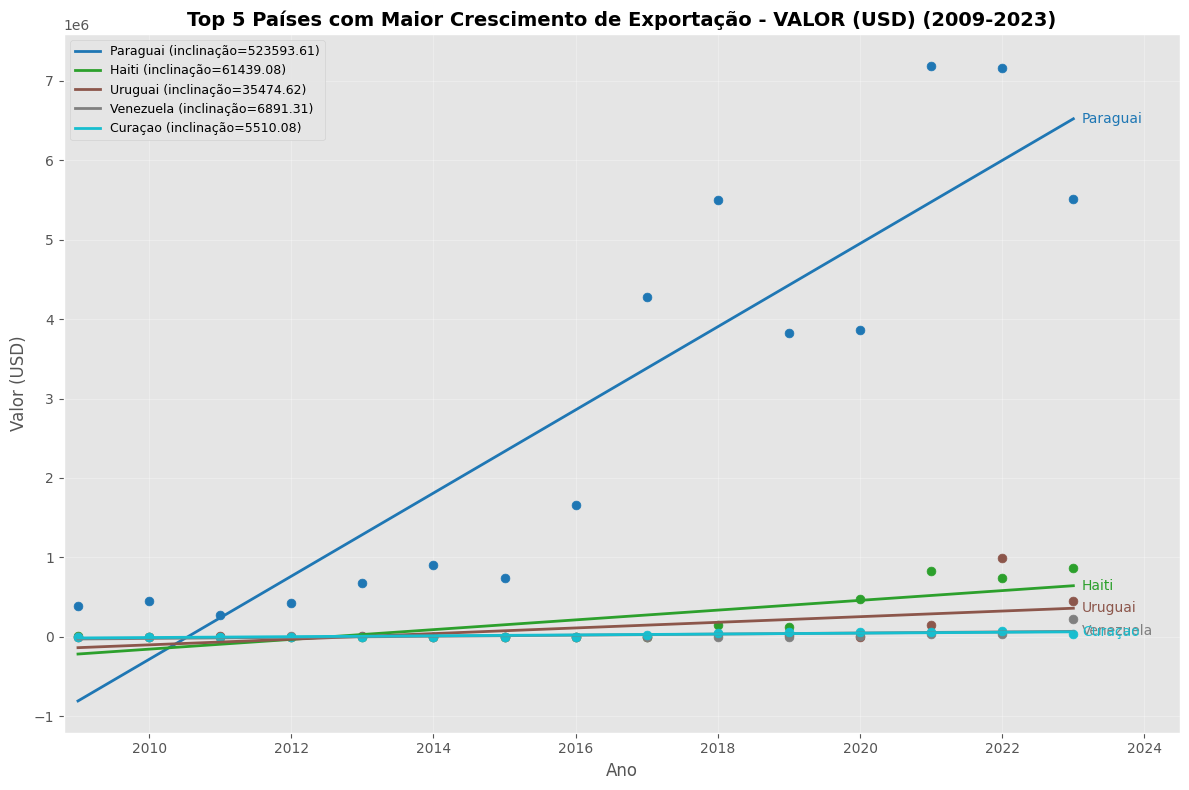

,País,Coeficiente_Angular,Equacao_Linear
0,Paraguai,523593.614286,y = 523593.61x + -1052707246.00
1,Haiti,61439.078571,y = 61439.08x + -123647925.80
2,Uruguai,35474.625000,y = 35474.62x + -71405234.07
3,Venezuela,6891.307143,y = 6891.31x + -13872252.53
4,Curaçao,5510.078571,y = 5510.08x + -11084219.07


Arquivo 'top5_exportacao_qtd_time.png' já existe.


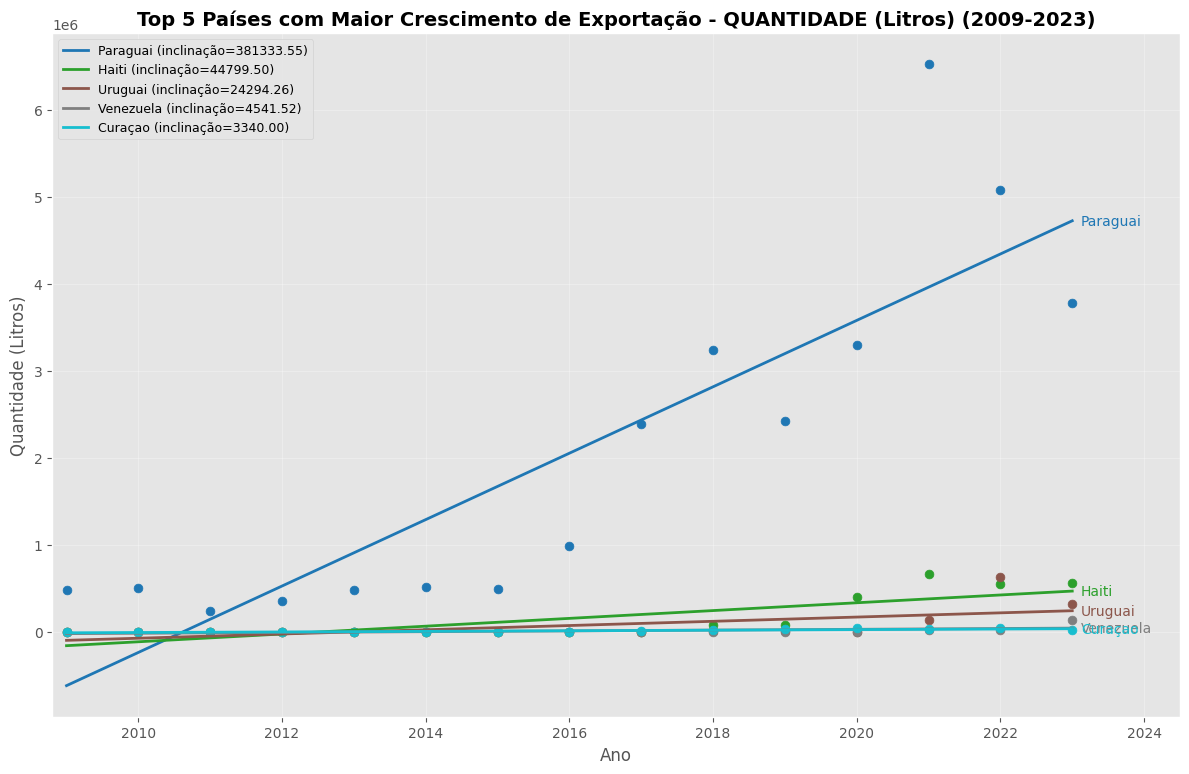

,País,Coeficiente_Angular,Equacao_Linear
0,Paraguai,381333.553571,y = 381333.55x + -766714894.20
1,Haiti,44799.496429,y = 44799.50x + -90159036.27
2,Uruguai,24294.260714,y = 24294.26x + -48902650.40
3,Venezuela,4541.525000,y = 4541.52x + -9142611.40
4,Curaçao,3339.996429,y = 3340.00x + -6719015.87


In [46]:
# Plotagem dos top5 para EXPORTAÇÃO usando funções compartilhadas (não repetir imports nem utilitários)
# Carregar os CSVs de regressão e séries temporais
import pandas as pd

df_reg_valor = pd.read_csv('regressao_exportacao_valor.csv')
df_reg_qtd = pd.read_csv('regressao_exportacao_qtd.csv')

df_valor_ts = pd.read_csv('exportacao_valor.csv')
df_qtd_ts = pd.read_csv('exportacao_qtd.csv')

# Chamar a função compartilhada de plotagem (definida na célula de utilitários)
plot_top5_time_series(
    df_reg_valor,
    df_valor_ts,
    'Top 5 Países com Maior Crescimento de Exportação - VALOR (USD) (2009-2023)',
    'Valor (USD)',
    'top5_exportacao_valor_time.png'
 )

plot_top5_time_series(
    df_reg_qtd,
    df_qtd_ts,
    'Top 5 Países com Maior Crescimento de Exportação - QUANTIDADE (Litros) (2009-2023)',
    'Quantidade (Litros)',
    'top5_exportacao_qtd_time.png'
 )

### Importação

In [47]:
# 1. Identar colunas de  2009 a 2023
year_cols = [str(year) for year in range(2009, 2024)]

# 2. Transformar df_importacao_filtrada em formato longo (melt)
df_importacao_long = importacao_qtd.melt(
    id_vars=['Id', 'País'],
    value_vars=year_cols,
    var_name='Ano',
    value_name='Valor_Exportado'
 )

# 3. Converter ano como inteiro
df_importacao_long['Ano'] = pd.to_numeric(df_importacao_long['Ano'])

print("DataFrame 'df_importacao_long' após transformação (melt):")
print(df_importacao_long.head())

# 4. Criar listas vazias para guardar os resultados
country_names = []
angular_coefficients = []
linear_coefficients = []
linear_equations = []

# 5. Iterar cada país
for country in df_importacao_long['País'].unique():
    # 6a. Filtrar por país
    country_df = df_importacao_long[df_importacao_long['País'] == country]

    # 6b. Verificar se há dados suficientes para regressão
    if len(country_df) < 2:
        country_names.append(country)
        angular_coefficients.append(None)
        linear_coefficients.append(None)
        linear_equations.append(f"{country}: Dados insuficientes para regressão")
        continue

    # 6c. Preparar os dados
    X = country_df['Ano'].values.reshape(-1, 1)  # Variável independente (Ano)
    y = country_df['Valor_Exportado'].values    # Variável dependente (Valor_Exportado)

    # 6d. Ajuste
    model = LinearRegression()
    model.fit(X, y)

    # 6e. Coeficientes
    coef_angular = model.coef_[0]
    coef_linear = model.intercept_

    # 6f. Formatar equação
    equation = f"y = {coef_angular:.2f}x + {coef_linear:.2f}"

    # 6g. Guardar nas listas
    country_names.append(country)
    angular_coefficients.append(coef_angular)
    linear_coefficients.append(coef_linear)
    linear_equations.append(equation)

# Criar um novo DataFrame com os resultados
df_regression_results = pd.DataFrame({
    'País': country_names,
    'Coeficiente_Angular': angular_coefficients,
    'Coeficiente_Linear': linear_coefficients,
    'Equacao_Linear': linear_equations
})

print("\nPrimeiras 5 linhas do DataFrame de resultados de regressão:")
print(df_regression_results.head())

# Exportar como CSV (nome em portugues)
arquivo = 'regressao_importacao_qtd.csv'
if not os.path.exists(arquivo):
    df_regression_results.to_csv(arquivo, index=False)
    print(f"DataFrame 'regressao_importacao_qtd' exportado para '{arquivo}'.")
else:
    print(f"Arquivo '{arquivo}' já está gerado.")

DataFrame 'df_importacao_long' após transformação (melt):
   Id            País   Ano  Valor_Exportado
0   1   Africa do Sul  2009           493093
1   2        Alemanha  2009            56075
2   3         Argélia  2009                0
3   4  Arábia Saudita  2009                0
4   5       Argentina  2009         13902750

Primeiras 5 linhas do DataFrame de resultados de regressão:
             País  Coeficiente_Angular  Coeficiente_Linear  \
0   Africa do Sul         11679.707143       -2.279200e+07   
1        Alemanha         -2275.371429        4.707824e+06   
2         Argélia             0.000000        0.000000e+00   
3  Arábia Saudita            49.042857       -9.866500e+04   
4       Argentina        881032.278571       -1.758504e+09   

                    Equacao_Linear  
0     y = 11679.71x + -22791995.60  
1       y = -2275.37x + 4707824.47  
2                 y = 0.00x + 0.00  
3           y = 49.04x + -98665.00  
4  y = 881032.28x + -1758503900.67  
Arquivo 'regress

In [48]:
# 1. Identar colunas de  2009 a 2023
year_cols = [str(year) for year in range(2009, 2024)]

# 2. Transformar df_importacao_valor em formato longo (melt)
df_importacao_long = importacao_valor.melt(
    id_vars=['Id', 'País'],
    value_vars=year_cols,
    var_name='Ano',
    value_name='Valor_Exportado'
 )

# 3. Converter ano como inteiro
df_importacao_long['Ano'] = pd.to_numeric(df_importacao_long['Ano'])

print("DataFrame 'df_importacao_long' após transformação (melt):")
print(df_importacao_long.head())

# 4. Criar listas vazias para guardar os resultados
country_names = []
angular_coefficients = []
linear_coefficients = []
linear_equations = []

# 5. Iterar cada país
for country in df_importacao_long['País'].unique():
    # 6a. Filtrar por país
    country_df = df_importacao_long[df_importacao_long['País'] == country]

    # 6b. Verificar se há dados suficientes para regressão
    if len(country_df) < 2:
        country_names.append(country)
        angular_coefficients.append(None)
        linear_coefficients.append(None)
        linear_equations.append(f"{country}: Dados insuficientes para regressão")
        continue

    # 6c. Preparar os dados
    X = country_df['Ano'].values.reshape(-1, 1)  # Variável independente (Ano)
    y = country_df['Valor_Exportado'].values    # Variável dependente (Valor_Exportado)

    # 6d. Ajuste
    model = LinearRegression()
    model.fit(X, y)

    # 6e. Coeficientes
    coef_angular = model.coef_[0]
    coef_linear = model.intercept_

    # 6f. Formatar equação
    equation = f"y = {coef_angular:.2f}x + {coef_linear:.2f}"

    # 6g. Guardar nas listas
    country_names.append(country)
    angular_coefficients.append(coef_angular)
    linear_coefficients.append(coef_linear)
    linear_equations.append(equation)

# Criar um novo DataFrame com os resultados
df_regression_results = pd.DataFrame({
    'País': country_names,
    'Coeficiente_Angular': angular_coefficients,
    'Coeficiente_Linear': linear_coefficients,
    'Equacao_Linear': linear_equations
})

print("\nPrimeiras 5 linhas do DataFrame de resultados de regressão:")
print(df_regression_results.head())

# Exportar como CSV (nome em portugues)
arquivo = 'regressao_importacao_valor.csv'
if not os.path.exists(arquivo):
    df_regression_results.to_csv(arquivo, index=False)
    print(f"DataFrame 'regressao_importacao_valor' exportado para '{arquivo}'.")
else:
    print(f"Arquivo '{arquivo}' já está gerado.")

DataFrame 'df_importacao_long' após transformação (melt):
   Id            País   Ano  Valor_Exportado
0   1   Africa do Sul  2009           493093
1   2        Alemanha  2009            56075
2   3         Argélia  2009                0
3   4  Arábia Saudita  2009                0
4   5       Argentina  2009         13902750

Primeiras 5 linhas do DataFrame de resultados de regressão:
             País  Coeficiente_Angular  Coeficiente_Linear  \
0   Africa do Sul         11679.707143       -2.279200e+07   
1        Alemanha         -2275.371429        4.707824e+06   
2         Argélia             0.000000        0.000000e+00   
3  Arábia Saudita            49.042857       -9.866500e+04   
4       Argentina        881032.278571       -1.758504e+09   

                    Equacao_Linear  
0     y = 11679.71x + -22791995.60  
1       y = -2275.37x + 4707824.47  
2                 y = 0.00x + 0.00  
3           y = 49.04x + -98665.00  
4  y = 881032.28x + -1758503900.67  
Arquivo 'regress

### Top 5 importação 

Arquivo 'top5_importacao_valor_time.png' já existe.


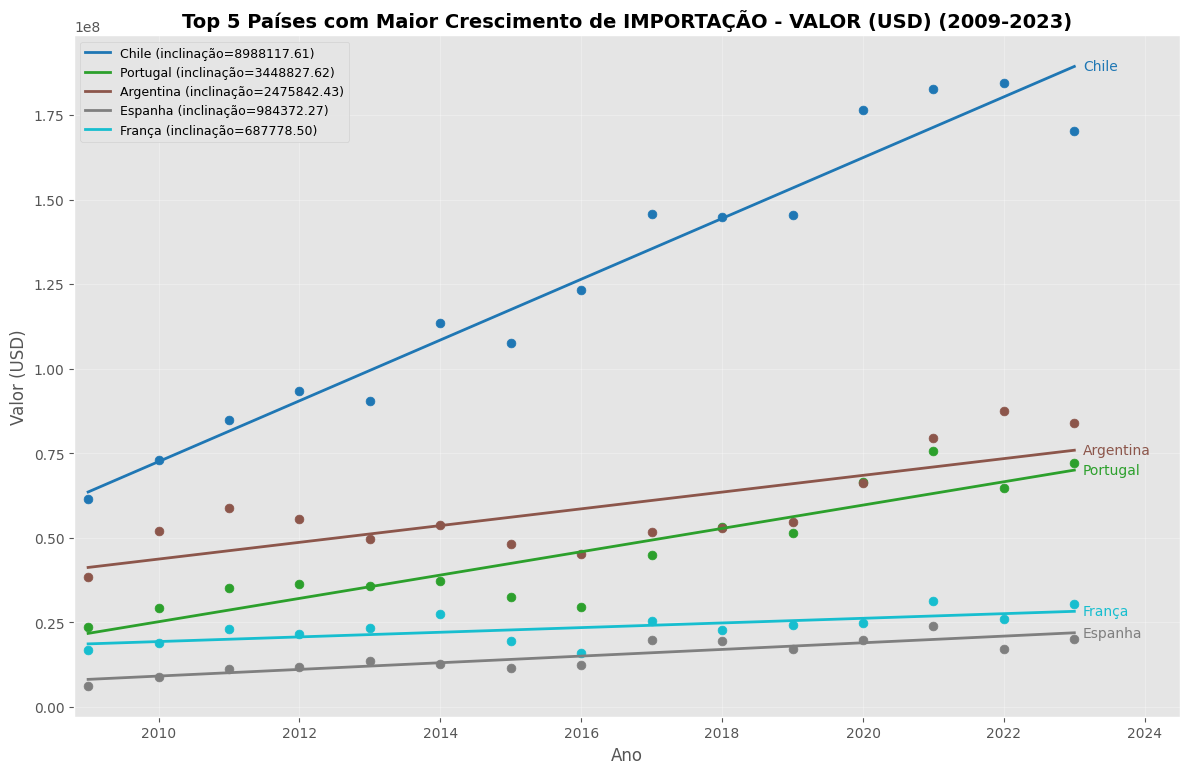

,País,Coeficiente_Angular,Equacao_Linear
0,Chile,8.988118e+06,y = 8988117.61x + -17993606566.33
1,Portugal,3.448828e+06,y = 3448827.62x + -6906985027.47
2,Argentina,2.475842e+06,y = 2475842.43x + -4932758886.00
3,Espanha,9.843723e+05,y = 984372.27x + -1969494974.73
4,França,6.877785e+05,y = 687778.50x + -1363141320.87


Arquivo 'top5_importacao_qtd_time.png' já existe.


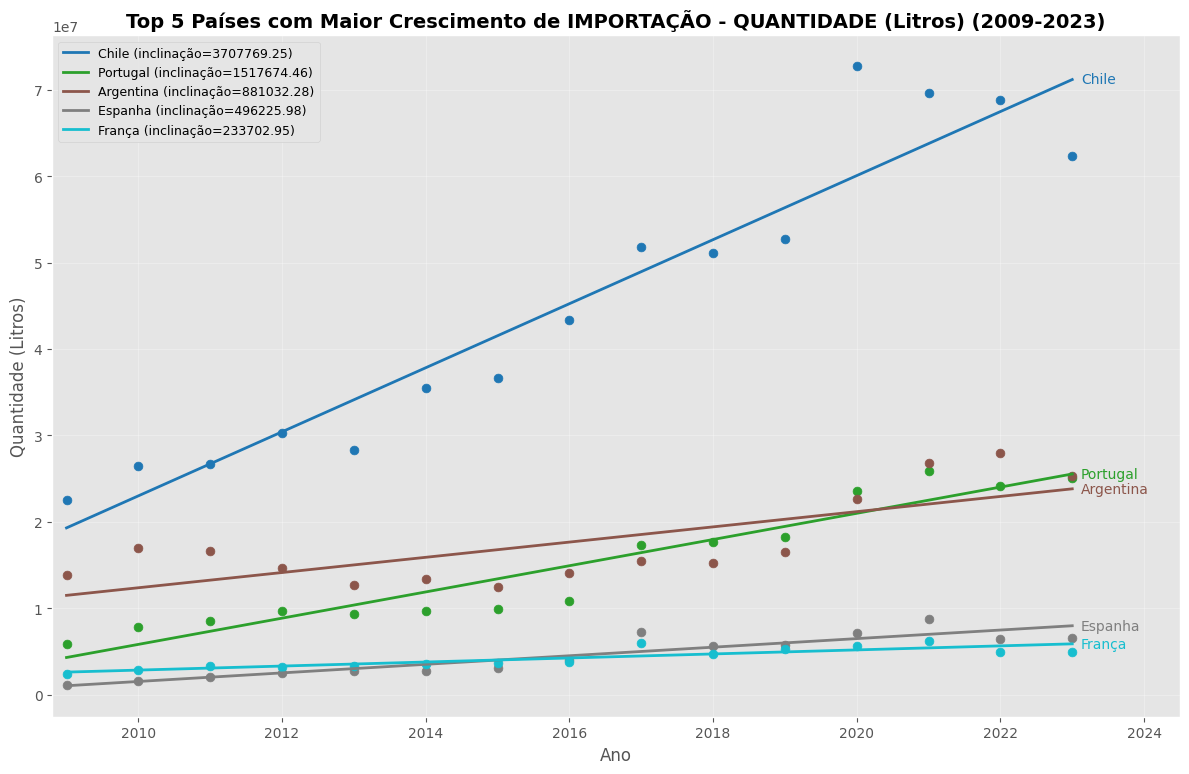

,País,Coeficiente_Angular,Equacao_Linear
0,Chile,3.707769e+06,y = 3707769.25x + -7429606682.87
1,Portugal,1.517674e+06,y = 1517674.46x + -3044711746.27
2,Argentina,8.810323e+05,y = 881032.28x + -1758503900.67
3,Espanha,4.962260e+05,y = 496225.98x + -995894005.33
4,França,2.337030e+05,y = 233702.95x + -466905143.33


In [49]:
# Plotagem dos top5 para IMPORTAÇÃO usando funções compartilhadas (não repetir imports nem utilitários)
# Carregar os CSVs de regressão e séries temporais de importação
import pandas as pd

# Notar: os arquivos de regressões foram renomeados para 'regressao_importacao_valor.csv' e 'regressao_importacao_qtd.csv'.
df_reg_import_valor = pd.read_csv('regressao_importacao_valor.csv')
df_reg_import_qtd = pd.read_csv('regressao_importacao_qtd.csv')

df_import_valor_ts = pd.read_csv('importacao_valor.csv')
df_import_qtd_ts = pd.read_csv('importacao_qtd.csv')

# Chamar a função compartilhada de plotagem
plot_top5_time_series(
    df_reg_import_valor,
    df_import_valor_ts,
    'Top 5 Países com Maior Crescimento de IMPORTAÇÃO - VALOR (USD) (2009-2023)',
    'Valor (USD)',
    'top5_importacao_valor_time.png'
 )

plot_top5_time_series(
    df_reg_import_qtd,
    df_import_qtd_ts,
    'Top 5 Países com Maior Crescimento de IMPORTAÇÃO - QUANTIDADE (Litros) (2009-2023)',
    'Quantidade (Litros)',
    'top5_importacao_qtd_time.png'
 )

## Comercialização

DataFrame 'df_exportacao_long' após transformação (melt):
   Id                             País   Ano  Valor_Exportado
0   1                      Afeganistão  2009                0
1   2                    África do Sul  2009                0
2   3  Alemanha, República Democrática  2009           225086
3   4                           Angola  2009            54786
4   5                         Anguilla  2009                0

Primeiras 5 linhas do DataFrame de resultados de regressão:
                              País  Coeficiente_Angular  Coeficiente_Linear  \
0                      Afeganistão             0.196429       -3.952667e+02   
1                    África do Sul             3.260714       -6.563800e+03   
2  Alemanha, República Democrática         -8612.428571        1.740586e+07   
3                           Angola         -2357.303571        4.761867e+06   
4                         Anguilla             0.000000        0.000000e+00   

                Equacao_Linear  
0

,name,rows,cols,duplicate_rows
0,exportacao_qtd,137,110,0
1,exportacao_qtd,137,110,0
2,exportacao_qtd,137,110,0


,Produto,start,end,CAGR
0,Outros produtos,418132.0,7459271.0,0.228526
1,Vinagre balsamico,36937.0,338926.0,0.171548
2,Borra líquida,12000.0,72600.0,0.137207
3,SUCO DE UVAS,29131455.0,166708720.0,0.132698
4,Vinagre duplo,426804.0,1769130.0,0.106903


,País,price_2009,price_2010,price_2011,price_2012,price_2013,price_2014,price_2015,price_2016,price_2017,price_2018,price_2019,price_2020,price_2021,price_2022,price_2023
0,Afeganistão,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
1,"Alemanha, República Democrática",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,Angola,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,NaN
3,Anguilla,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Antilhas Holandesas,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


,País,Coeficiente_Angular,Coeficiente_Linear,Equacao_Linear
0,Afeganistão,NaN,NaN,Dados insuficientes
1,"Alemanha, República Democrática",0.0,1.0,y = 0.0000x + 1.0000
2,Angola,0.0,1.0,y = 0.0000x + 1.0000
3,Antilhas Holandesas,0.0,1.0,y = 0.0000x + 1.0000
4,Antígua e Barbuda,0.0,1.0,y = 0.0000x + 1.0000


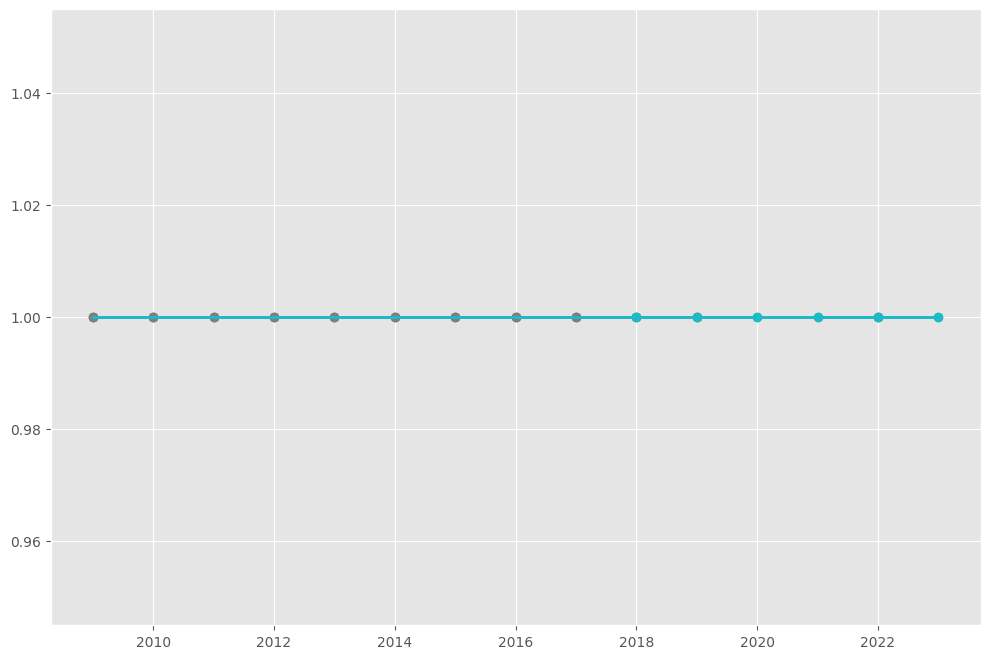

In [50]:
# Gerar tabelas `exportacao_tot` e `importacao_tot` (2009-2023)
# Verifica existência dos CSVs e usa os DataFrames filtrados quando disponíveis
import os
import unicodedata

# coletor de caminhos/saídas do notebook
outputs = {}

# Normalização para encontrar colunas de país
def _normalize(s):
    if not isinstance(s, str):
        return ''
    nk = unicodedata.normalize('NFKD', s)
    return ''.join(c for c in nk if not unicodedata.combining(c)).strip().lower()

# Busca primeiro DataFrame disponível na lista de nomes
def _find_df(names):
    for n in names:
        if n in globals():
            return globals()[n], n
    return None, None

# Gera tabela total (coluna país + total) e salva CSV se não existir
def _create_tot(df_names, csv_name):
    if os.path.exists(csv_name):
        print(f"Arquivo '{csv_name}' já existe. Carregando...")
        df_tot = pd.read_csv(csv_name)
        display(df_tot.head())
        return

    df, used_name = _find_df(df_names)
    if df is None:
        print(f"Nenhum DataFrame encontrado entre: {df_names}. Pulando '{csv_name}'.")
        return

    # Detectar coluna de país de forma robusta
    country_col = None
    for col in df.columns:
        n = _normalize(col)
        if n in {'pais', 'país', 'country'} or 'pais' in n or 'country' in n:
            country_col = col
            break

    if country_col is None:
        print(f"Não foi possível localizar coluna de país em '{used_name}'. Colunas: {list(df.columns)}")
        return

    anos = [str(y) for y in range(2009, 2024)]
    anos_presentes = [c for c in anos if c in df.columns]
    if not anos_presentes:
        print(f"Nenhuma coluna de ano (2009-2023) encontrada em '{used_name}'.")
        return

    # Garantir que colunas anuais sejam numéricas
    for c in anos_presentes:
        df[c] = pd.to_numeric(df[c].astype(str).str.replace(',', '.'), errors='coerce').fillna(0)

# 1. Identar colunas de  2009 a 2023
year_cols = [str(year) for year in range(2009, 2024)]
# Garantir que 'exportacao_qtd' exista; fallback para 'df_exportacao'
if 'exportacao_qtd' not in globals():
    try:
        exportacao_qtd = df_exportacao.copy()
        print("Variável 'exportacao_qtd' criada a partir de 'df_exportacao' (fallback).")
    except Exception as e:
        print("Não foi possível criar 'exportacao_qtd' a partir de 'df_exportacao':", e)
        exportacao_qtd = None
if exportacao_qtd is None:
    print("Pulando regressão de exportação: 'exportacao_qtd' ausente.")
else:
    # 2. Transformar df_exportacao_filtrada em formato longo (melt)
    df_exportacao_long = exportacao_qtd.melt(
        id_vars=['Id', 'País'],
        value_vars=year_cols,
        var_name='Ano',
        value_name='Valor_Exportado'
     )

    # 3. Converter ano como inteiro
    df_exportacao_long['Ano'] = pd.to_numeric(df_exportacao_long['Ano'])

    print("DataFrame 'df_exportacao_long' após transformação (melt):")
    print(df_exportacao_long.head())

    # 4. Criar listas vazias para guardar os resultados
    country_names = []
    angular_coefficients = []
    linear_coefficients = []
    linear_equations = []

    # 5. Iterar cada país
    for country in df_exportacao_long['País'].unique():
        # 6a. Filtrar por país
        country_df = df_exportacao_long[df_exportacao_long['País'] == country]

        # 6b. Verificar se há dados suficientes para regressão
        if len(country_df) < 2:
            country_names.append(country)
            angular_coefficients.append(None)
            linear_coefficients.append(None)
            linear_equations.append(f"{country}: Dados insuficientes para regressão")
            continue

        # 6c. Preparar os dados
        X = country_df['Ano'].values.reshape(-1, 1)  # Variável independente (Ano)
        y = country_df['Valor_Exportado'].values    # Variável dependente (Valor_Exportado)

        # 6d. Ajuste
        model = LinearRegression()
        model.fit(X, y)

        # 6e. Coeficientes
        coef_angular = model.coef_[0]
        coef_linear = model.intercept_

        # 6f. Formatar equação
        equation = f"y = {coef_angular:.2f}x + {coef_linear:.2f}"

        # 6g. Guardar nas listas
        country_names.append(country)
        angular_coefficients.append(coef_angular)
        linear_coefficients.append(coef_linear)
        linear_equations.append(equation)

    # Criar um novo DataFrame com os resultados
    df_regression_results = pd.DataFrame({
        'País': country_names,
        'Coeficiente_Angular': angular_coefficients,
        'Coeficiente_Linear': linear_coefficients,
        'Equacao_Linear': linear_equations
    })

    print("\nPrimeiras 5 linhas do DataFrame de resultados de regressão:")
    print(df_regression_results.head())

    # Exportar como CSV (nome em portugues)
    arquivo = 'regressao_exportacao_qtd.csv'
    if not os.path.exists(arquivo):
        df_regression_results.to_csv(arquivo, index=False)
        print(f"DataFrame 'regressao_exportacao_qtd' exportado para '{arquivo}'.")
    else:
        print(f"Arquivo '{arquivo}' já está gerado.")
    # Garantir que exista uma lista de relatório de qualidade e fornecer valores fallback seguros
    if 'dq_report' not in globals():
        dq_report = []
    try:
        name = 'exportacao_qtd'
        if 'exportacao_qtd' in globals() and exportacao_qtd is not None:
            rows, cols = exportacao_qtd.shape
            dup = int(exportacao_qtd.duplicated().sum())
            cols_info = [{'name': c, 'non_null': int(exportacao_qtd[c].notnull().sum()), 'dtype': str(exportacao_qtd[c].dtype)} for c in exportacao_qtd.columns]
        else:
            # fallback para o DataFrame resultante da regressão
            rows, cols = df_regression_results.shape
            dup = int(df_regression_results.duplicated().sum())
            cols_info = [{'name': c, 'non_null': int(df_regression_results[c].notnull().sum()), 'dtype': str(df_regression_results[c].dtype)} for c in df_regression_results.columns]
    except Exception:
        name = 'exportacao_qtd'
        rows = cols = dup = 0
        cols_info = []
    dq_report.append({'name': name, 'rows': int(rows), 'cols': int(cols), 'duplicate_rows': int(dup), 'columns': cols_info})

# salvar relatorio de qualidade com nome em portugues
with open('relatorio_qualidade_dados.json', 'w', encoding='utf-8') as fh:
    json.dump(dq_report, fh, ensure_ascii=False, indent=2)

pd.DataFrame([{'name': r['name'], 'rows': r['rows'], 'cols': r['cols'], 'duplicate_rows': r['duplicate_rows']} for r in dq_report]).to_csv('resumo_qualidade_dados.csv', index=False)
print('Qualidade dos dados salva: relatorio_qualidade_dados.json / resumo_qualidade_dados.csv')
outputs['dq'] = 'resumo_qualidade_dados.csv'

# 2) CAGR (Taxa de Crescimento Anual Composta) para comercializacao — agrupar por país se disponível, senão por produto.
# CAGR mede o crescimento médio anual entre o primeiro e o último ano da série e é útil para comparar tendências.
com_fname = None
if 'comercializacaofiltrada' in globals():
    dfc = globals()['comercializacaofiltrada']
elif 'df_comercializacao' in globals():
    dfc = globals()['df_comercializacao']
else:
    dfc = None

cagr_path = 'cagr_comercializacao.csv'
if dfc is None:
    print('Nenhum DataFrame de comercializacao em memória; pulando CAGR')
else:
    # garantir colunas anuais numéricas quando presentes
    years_present = [y for y in YEARS if y in dfc.columns]
    for y in years_present:
        dfc[y] = pd.to_numeric(dfc[y].astype(str).str.replace(',', '.'), errors='coerce').fillna(0)

    # detectar coluna de agrupamento: país ou produto
    group_col = None
    for c in dfc.columns:
        n = _normalize(c)
        if any(k in n for k in ['pais', 'country']):
            group_col = c
            break
    if group_col is None:
        for c in dfc.columns:
            n = _normalize(c)
            if any(k in n for k in ['produto', 'product', 'produto', 'class']):
                group_col = c
                break
    if group_col is None:
        # fallback: calcular CAGR overall
        if years_present:
            start = dfc[years_present[0]].sum()
            end = dfc[years_present[-1]].sum()
            n = len(years_present)-1
            cagr = (end / start) ** (1.0 / n) - 1 if start>0 and n>0 else np.nan
            pd.DataFrame([{'level': 'overall', 'start': start, 'end': end, 'CAGR': cagr}]).to_csv(cagr_path, index=False)
            print('CAGR geral salvo em', cagr_path)
            outputs['cagr'] = cagr_path
        else:
            print('Nenhuma coluna anual encontrada para comercializacao')
    else:
        grp = dfc.groupby(group_col)[years_present].sum(numeric_only=True)
        rows = []
        for idx, row in grp.iterrows():
            s = row[years_present[0]]
            e = row[years_present[-1]]
            n = len(years_present)-1
            if s>0 and n>0:
                val = (e / s) ** (1.0/n) - 1
            else:
                val = np.nan
            rows.append({group_col: idx, 'start': float(s), 'end': float(e), 'CAGR': val})
        pd.DataFrame(rows).sort_values('CAGR', ascending=False).to_csv(cagr_path, index=False)
        print('CAGR por', group_col, 'salvo em', cagr_path)
        outputs['cagr'] = cagr_path

# 3) Preço por litro para exportação (merge exportacao_qtd e exportacao_valor se disponíveis)
price_path = 'preco_por_litro_exportacao.csv'
if 'exportacao_qtd' in globals() and 'exportacao_valor' in globals():
    qtd = globals()['exportacao_qtd'].copy()
    val = globals()['exportacao_valor'].copy()
    # normalizar colunas de ano
    for y in YEARS:
        if y in qtd.columns:
            qtd[y] = pd.to_numeric(qtd[y].astype(str).str.replace(',', '.'), errors='coerce').fillna(0)
        if y in val.columns:
            val[y] = pd.to_numeric(val[y].astype(str).str.replace(',', '.'), errors='coerce').fillna(0)
    # encontrar chaves de junção
    join_keys = [k for k in ['Id','País','Pais','Country'] if k in qtd.columns and k in val.columns]
    if not join_keys:
        non_year_q = [c for c in qtd.columns if c not in YEARS]
        non_year_v = [c for c in val.columns if c not in YEARS]
        common = [c for c in non_year_q if c in non_year_v]
        join_keys = common
    if join_keys:
        merged = pd.merge(qtd, val, on=join_keys, how='inner', suffixes=('_q','_v'))
        # calcular colunas de preço
        price_cols = []
        for y in YEARS:
            qcol = y if y in merged.columns else (f'{y}_q' if f'{y}_q' in merged.columns else None)
            vcol = y if y in merged.columns else (f'{y}_v' if f'{y}_v' in merged.columns else None)
            if qcol and vcol and qcol in merged.columns and vcol in merged.columns:
                merged[f'price_{y}'] = merged[vcol].replace({0: np.nan}) / merged[qcol].replace({0: np.nan})
                price_cols.append(f'price_{y}')
        # agregar preço médio por país se existir a chave país
        country_key = None
        for k in ['País','Pais','country','Country']:
            if k in merged.columns:
                country_key = k
                break
        if country_key and price_cols:
            df_price = merged.groupby(country_key)[price_cols].mean().reset_index()
            df_price.to_csv(price_path, index=False)
            print('Preço por litro salvo em', price_path)
            outputs['price'] = price_path
        else:
            print('Não foi possível agregar preço por litro por país (chave ausente ou colunas de preço faltando)')
else:
    print('DataFrames exportacao_qtd/exportacao_valor não encontrados em memória; pulando cálculo de preço')

# 4) Regressão linear do preço por litro para os 5 países com maior preço médio (2009-2023)
# Gera CSV de regressões e um gráfico com séries e retas de regressão para os top5
reg_csv = 'regressao_preco_por_litro_top5.csv'
reg_plot = 'top5_preco_por_litro_time.png'

try:
    if os.path.exists(price_path):
        df_price = pd.read_csv(price_path, engine='python')
        # detectar colunas de preço: price_2009 ... price_2023 ou 2009..2023
        price_year_cols = [c for c in df_price.columns if c.startswith('price_')]
        if not price_year_cols:
            # verificar se há colunas numéricas 2009..2023
            price_year_cols = [c for c in df_price.columns if c in YEARS]
        if not price_year_cols:
            print('Nenhuma coluna de preço por ano encontrada em', price_path)
        else:
            # calcular média e selecionar top5 pelo último ano disponível ou média
            last_year = max([int(c.split('_')[-1]) if c.startswith('price_') else int(c) for c in price_year_cols])
            # usar média sobre anos disponíveis
            df_price['mean_price'] = df_price[price_year_cols].replace({0: np.nan}).mean(axis=1, skipna=True)
            top5 = df_price.sort_values('mean_price', ascending=False).head(5)
            top5_countries = top5.iloc[:,0].tolist()

            from sklearn.linear_model import LinearRegression
            import matplotlib.pyplot as plt

            rows = []
            plt.figure(figsize=(12,8))
            cores = plt.cm.tab10(np.linspace(0,1,5))
            for i, country in enumerate(top5_countries):
                row = df_price[df_price.iloc[:,0] == country]
                if row.empty:
                    continue
                y_vals = []
                yrs = []
                for col in price_year_cols:
                    yrs.append(int(col.split('_')[-1]) if col.startswith('price_') else int(col))
                    y_vals.append(float(row.iloc[0][col]) if pd.notna(row.iloc[0][col]) else np.nan)
                X = np.array(yrs).reshape(-1,1)
                y = np.array(y_vals, dtype=float)
                mask = ~np.isnan(y)
                if mask.sum() < 2:
                    rows.append({'País': country, 'Coeficiente_Angular': np.nan, 'Coeficiente_Linear': np.nan, 'Equacao_Linear': 'Dados insuficientes'})
                    continue
                model = LinearRegression()
                model.fit(X[mask], y[mask])
                slope = float(model.coef_[0])
                intercept = float(model.intercept_)
                eq = f"y = {slope:.4f}x + {intercept:.4f}"
                rows.append({'País': country, 'Coeficiente_Angular': slope, 'Coeficiente_Linear': intercept, 'Equacao_Linear': eq})

                # plot
                X_full = np.array(yrs)
                y_line = model.predict(X_full.reshape(-1,1))
                plt.plot(X_full, y_line, color=cores[i], linestyle='-', linewidth=2, label=f"{country} (inclinação={slope:.4f})")
                plt.scatter(X_full[mask], y[mask], color=cores[i], s=40)

            pd.DataFrame(rows).to_csv(reg_csv, index=False)
            try:
                if not os.path.exists(reg_plot):
                    plt.title('Top 5 Países por Preço Médio por Litro - Séries e Regressões (2009-2023)')
                    plt.xlabel('Ano')
                    plt.ylabel('Preço por litro (USD ou moeda)')
                    plt.grid(alpha=0.3)
                    plt.legend()
                    plt.tight_layout()
                    plt.savefig(reg_plot, dpi=300, bbox_inches='tight')
                    print('Gráfico salvo em', reg_plot)
                else:
                    print('Arquivo de gráfico já existe:', reg_plot)
            except Exception as e:
                print('Erro ao salvar gráfico:', e)
            print('Regressões salvas em', reg_csv)
            outputs['reg_preco_top5'] = reg_csv
    else:
        print('Arquivo', price_path, 'não encontrado; não foi possível gerar regressões de preço por litro.')
except Exception as e:
    print('Erro no cálculo/regressão de preço por litro:', e)

# Mostrar resultados resumidos
print('\nSaídas geradas:', outputs)
if 'dq' in outputs:
    display(pd.read_csv(outputs['dq']).head())
if 'cagr' in outputs:
    display(pd.read_csv(outputs['cagr']).head())
if 'price' in outputs:
    display(pd.read_csv(outputs['price']).head())
if 'reg_preco_top5' in outputs:
    display(pd.read_csv(outputs['reg_preco_top5']).head())